# PyBaMM show and tell

PyBaMM is an open-source package to simulate physics-based models for lithium-ion batteries using state-of-the-art techniques.  The package is built on Python, and provides a flexible platform for implementation and comparison of new models and numerical methods, and an easy interaction with other Python packages. PyBaMM includes a broad range of standard and cutting-edge models for lithium-ion batteries including electrochemical, thermal and degradation effects.

PyBaMM can easily be installed from Python Package Index (PyPI) with a single line of code in your terminal:

In [1]:
%pip install pybamm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Planel_F\pybamm-supporting-material\env\Scripts\python.exe -m pip install --upgrade pip' command.


This might take a few minutes and will install PyBaMM and all the necessary dependencies in your computer, no matter if you use Windows, Linux or MacOs.

## Basic example

PyBaMM includes the standard physics-based model for lithium-ion batteries, such as the Doyle-Fuller-Newman (DFN) model, also known as the Newman model or the pseudo-two-dimensional (P2D) model. This model can be solved with a few lines of code:

In [2]:
import pybamm

model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model)
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## Compare models

PyBaMM also includes other standard models, such as the Single Particle Model (with and without electrolyte). Due to PyBaMM's structure, it is very easy to compare different models.

In [3]:
models = [
    pybamm.lithium_ion.SPM(),
    pybamm.lithium_ion.SPMe(),
    pybamm.lithium_ion.DFN(),
]

sims = []
for model in models:
    sim = pybamm.Simulation(model)
    sim.solve([0, 3600])
    sims.append(sim)
    
pybamm.dynamic_plot(sims)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## Change parameter values

So far we have run the models with the default parameter sets, but PyBaMM includes various parameter sets for different chemistries. It also allows users to define their own parameter sets. For example, to use the parameters for NMC 811 and graphite-SiO$_x$ from Chen et al. (2020), we simply need to add an additional line of code.

In [4]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020")
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3554.1817016740947, step=35.54181701674095),…

Following open-science principles, PyBaMM provides a list of the references used for the different components of the code (e.g. model, parameters, numerical solvers...). Adding `pybamm.print_citations()` at the end of the script provides a list with all the relevant citations.

In [5]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with

For example, in this case we have Andersson et al. (2019) for the CasADI solver, Chen et al. (2020) for the parameter set, or Doyle et al. (1993) for the model.

## Run experiments

So far we have seen constant current discharges, but usually we want to simulate more complex cycles. This can be done using the `Experiment` class. The various steps of the experiment are defined in words and PyBaMM automatically assembles the correct model.

In [6]:
model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
    [
        ("Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour"),
    ] * 3
)


sim = pybamm.Simulation(model, experiment=experiment)
sim.solve()
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=38.90905257815937, step=0.3890905257815937),…

This feature also allows to easily simulate drive cycles from data

In [7]:
import pandas as pd

model = pybamm.lithium_ion.SPMe()

# import drive cycle from file
US06 = pd.read_csv("US06.csv", comment="#", header=None).to_numpy()

experiment = pybamm.Experiment(
    [
        "Run US06 (A) for 5 minutes",
        "Rest for 5 minutes",
        "Run US06 (A) for 10 minutes",
    ],
    drive_cycles={"US06": US06}
)


sim = pybamm.Simulation(model, experiment=experiment)
sim.solve()
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1200.0, step=12.0), Output()), _dom_classes=…

## Thermal models

Show different thermal model options:
* Pouch
* Lumped

## Degradation models

PyBaMM allows to add degradation effects on top of the electrochemical models. There are multiple degradation models corresponding to various effects:

* SEI: reaction, solvent-diffusion limited, electron-migration limited, interstitial-diffusion limited, ec reaction limited...
* Lithium plating: irreversible and reversible
* Mechanics

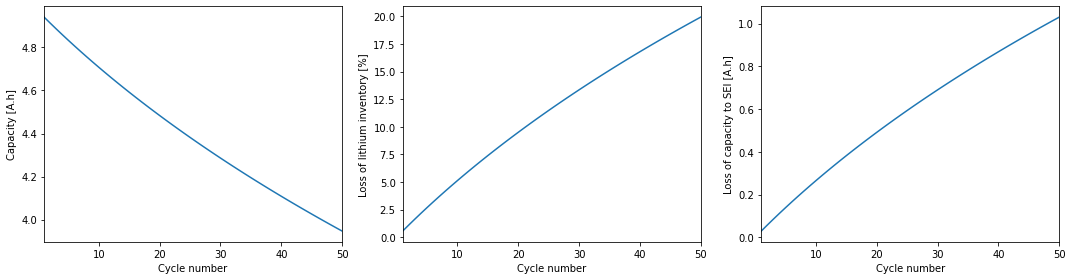

array([<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
       <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
       <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
      dtype=object)

In [8]:
model = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})

experiment = pybamm.Experiment(
    [("Discharge at 1C until 3 V",
     "Rest for 1 hour",
     "Charge at 1C until 4.2 V", 
     "Hold at 4.2 V until C/50")] * 500,
    termination="80% capacity"
)

sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve(initial_soc=1)

pybamm.plot_summary_variables(
    sol, 
    output_variables=["Capacity [A.h]", "Loss of lithium inventory [%]", "Loss of capacity to SEI [A.h]"],
    figsize=(15,4)
)

## Particle size distributions

Show some examples of PSD models ?

## liionpack example?

Do we want to show a small example of liionpack?

In [9]:
%pip install liionpack

  Using cached liionpack-0.3-py3-none-any.whl (28 kB)
  Using cached tqdm-4.63.0-py2.py3-none-any.whl (76 kB)
  Using cached dask-2022.2.0-py3-none-any.whl (1.1 MB)
  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)



ERROR: Could not find a version that satisfies the requirement ray (from liionpack) (from versions: none)
ERROR: No matching distribution found for ray
You should consider upgrading via the 'C:\Users\Planel_F\pybamm-supporting-material\env\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached openpyxl-3.0.9-py2.py3-none-any.whl (242 kB)
  Using cached scikit_spatial-6.3.0-py3-none-any.whl (44 kB)


In [11]:
import liionpack as lp
import numpy as np
import os

# Generate the netlist
netlist = lp.setup_circuit(Np=16, Ns=2)

# Define additional output variables
output_variables = ['Volume-averaged cell temperature [K]']

# Define a cycling experiment using PyBaMM
experiment = pybamm.Experiment([
    'Charge at 20 A for 30 minutes',
    'Rest for 15 minutes',
    'Discharge at 20 A for 30 minutes',
    'Rest for 30 minutes'],
    period='10 seconds')

# Define the PyBaMM parameters
parameter_values = pybamm.ParameterValues(chemistry="Chen2020")
inputs = {"Total heat transfer coefficient [W.m-2.K-1]": np.ones(Np * Ns) * 10}

# Solve the pack
output = lp.solve(netlist=netlist,
                  sim_func=lp.thermal_simulation,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  output_variables=output_variables,
                  initial_soc=0.5,
                  inputs=inputs,
                  nproc=os.cpu_count(),
                  manager='casadi')

# Plot the pack and individual cell results
lp.plot_pack(output)
lp.plot_cells(output)
lp.show_plots()

ModuleNotFoundError: No module named 'liionpack'